In [1]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

Populating the interactive namespace from numpy and matplotlib


In [2]:
results = pd.read_csv('MOB_final_results.csv', index_col=0).query('g != "log_total_count"')
ms_results = pd.read_csv('MOB_MS_results.csv', index_col=0).query('g != "log_total_count"')

results['pval'] = results['pval'].clip_lower(results.query('pval > 0')['pval'].min() / 2)
results['qval'] = results['qval'].clip_lower(results.query('qval > 0')['qval'].min() / 2)

sample_info = pd.read_csv('MOB_sample_info.csv', index_col=0)

df = pd.read_csv('data/Rep11_MOB_0.csv', index_col=0)
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes
sample_info = sample_info.query('total_counts > 10')  # Remove empty features
df = df.loc[sample_info.index]

In [3]:
import NaiveDE
dfm = NaiveDE.stabilize(df.T).T

In [4]:
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

In [5]:
import SpatialDE

In [6]:
def se_kernel_pred(X1, X2, l):
    X1sq = np.sum(np.square(X1), 1)
    X2sq = np.sum(np.square(X2), 1)
    R2 = -2. * np.dot(X1, X2.T) + (X1sq[:, None] + X2sq[None, :])
    R2 = np.clip(R2, 1e-12, np.inf)
    
    return np.exp(-R2 / (2 * l ** 2))

In [7]:
def cosine_kernel_pred(X1, X2, p):
    X1sq = np.sum(np.square(X1), 1)
    X2sq = np.sum(np.square(X2), 1)
    R2 = -2. * np.dot(X1, X2.T) + (X1sq[:, None] + X2sq[None, :])
    R2 = np.clip(R2, 1e-12, np.inf)
    
    return np.cos(2 * np.pi * np.sqrt(R2) / p)

In [8]:
def make_sliver(sample_info, b=30., a=1., oo=35):
    xx = np.linspace(0.8 * sample_info.x.min(), 1.2 * sample_info.x.max())
    yy = b + a * xx
    
    sliver = sample_info.query('y - @oo < @b + @a * x < y + @oo')
    
    return sliver, xx, yy

In [9]:
def plot_sliver(sample_info, sliver, xx, yy):
    plt.scatter(sample_info.x, sample_info.y, c='lightgrey')
    plt.scatter(sliver.x, sliver.y, c='k')
    plt.plot(xx, yy, c='tab:red')
    plt.axis('equal');
    plt.gca().invert_yaxis()
    plt.xlabel('x (µm)')
    plt.ylabel('y (µm)');

In [19]:
def predict_gp(X_new, Y, K, K_s, s2, delta, mu):
    Y_new = mu + s2 * K_s.dot(np.linalg.solve(s2 * K + s2 * delta * np.eye(K.shape[0]), Y - mu))
    return Y_new

In [20]:
def plot_sliver_expr(sample_info, sliver, Ys):
    plt.scatter(X.x, Ys, c='lightgrey')
    plt.scatter(sliver.x, Ys.loc[sliver.index], c='k');

In [44]:
g = "Penk"
X = sample_info[['x', 'y']]
Y = res[g][:, None]

params = results.query('g == @g').iloc[0]
l = params['l']
K_s = SpatialDE.base.SE_kernel(X, l)

n = K_s.shape[0]
U, S = SpatialDE.base.factor(K_s)
UT1 = SpatialDE.base.get_UT1(U)
UTy = SpatialDE.base.get_UTy(U, Y[:, 0])

max_ll, max_delta, max_mu_hat, max_s2_t_hat, s2_logdelta = \
SpatialDE.base.lbfgsb_max_LL(UTy, UT1, S, n)

-163.052024043 s
-164.154141123 p
-163.052024043 s
-164.154141123 p
-163.052024043 s
-164.154141123 p


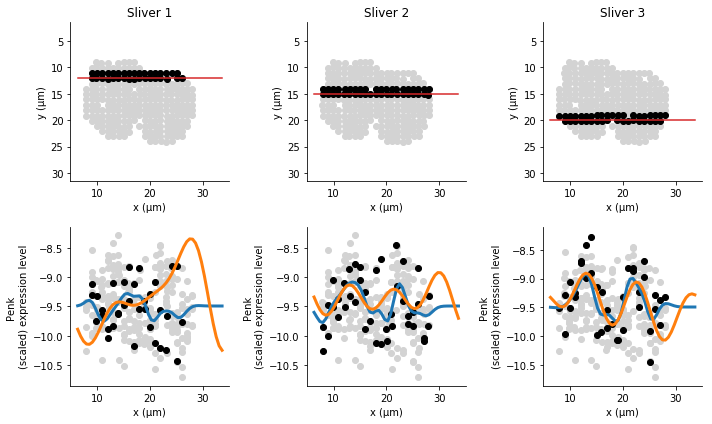

In [74]:
g = "Penk"
X = sample_info[['x', 'y']]
Y = res[g][:, None]

figsize(10, 6)

for i, b in enumerate([12, 15, 20]):
    ## Sliver in 2D context

    plt.subplot(2, 3, i + 1)

    sliver, xx, yy = make_sliver(sample_info, b, a=0, oo=1.)
    plot_sliver(sample_info, sliver, xx, yy)
    plt.title('Sliver {}'.format(i + 1))
    
    plt.subplot(2, 3, i + 1 + 3)
    
    ## Sliver in expression context

    X_new = np.vstack((xx, yy)).T
    
    plot_sliver_expr(sample_info, sliver, res[g])
    
    ## SE model
    
    params = results.query('g == @g').iloc[0]
    l = params['l']
    
    K_s = SpatialDE.base.SE_kernel(X, l)
    K_s_s = se_kernel_pred(X_new, X, l)

    n = K_s.shape[0]
    U, S = SpatialDE.base.factor(K_s)
    UT1 = SpatialDE.base.get_UT1(U)
    UTy = SpatialDE.base.get_UTy(U, Y[:, 0])

    max_ll, max_delta, max_mu_hat, max_s2_t_hat, s2_logdelta = \
    SpatialDE.base.lbfgsb_max_LL(UTy, UT1, S, n)
    
    mu = max_mu_hat
    s2 = max_s2_t_hat
    delta = max_delta
    
    Y_new = predict_gp(X_new, Y, K_s, K_s_s, s2, delta, mu)
    
    plt.plot(X_new[:, 0], Y_new, c='C0', lw=3)
    print(max_ll, 's')
    
    ## periodic model
    
    p_params = ms_results.query('g == @g').iloc[0]
    p = p_params['l']
    p = 9.0
    
    K_p = SpatialDE.base.cosine_kernel(X, p)
    K_p_s = cosine_kernel_pred(X_new, X, p)
    
    n = K_p.shape[0]
    U, S = SpatialDE.base.factor(K_p)
    UT1 = SpatialDE.base.get_UT1(U)
    UTy = SpatialDE.base.get_UTy(U, Y[:, 0])
    
    max_ll, max_delta, max_mu_hat, max_s2_t_hat, s2_logdelta = \
    SpatialDE.base.lbfgsb_max_LL(UTy, UT1, S, n)
    
    mu = max_mu_hat
    s2 = max_s2_t_hat
    delta = max_delta
    
    Y_new = predict_gp(X_new, Y, K_p, K_p_s, s2, delta, mu)
    
    plt.plot(X_new[:, 0], Y_new, c='C1', lw=3)
    print(max_ll, 'p')
    
    ## Labels etc
    
#     plt.ylim(-12, -8);
    plt.xlabel('x (µm)')
    plt.ylabel(f'{g} \n(scaled) expression level');
    
plt.tight_layout()

In [68]:
max_ll

-164.15414112320173

In [48]:
p_params

BIC                 348.347
FSV                0.334516
LLR                  16.074
M                         4
g                      Penk
l                   1.13519
max_delta            1.9425
max_ll             -163.052
max_mu_hat          -9.4918
max_s2_t_hat        10.3641
model                    SE
n                       260
s2_FSV          0.000699317
s2_logdelta       0.0157558
time            0.000972986
PER_prob           0.116356
SE_prob            0.883644
linear_prob     2.51426e-12
pval            6.09154e-05
qval              0.0201156
max_ll_null        -179.126
Name: 29, dtype: object

-213.01709204 s
-205.516401803 p
-213.01709204 s
-205.516401803 p
-213.01709204 s
-205.516401803 p


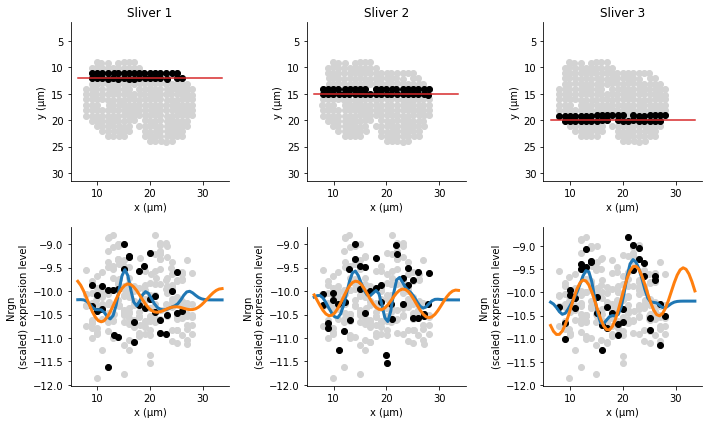

In [72]:
g = "Nrgn"
X = sample_info[['x', 'y']]
Y = res[g][:, None]

figsize(10, 6)

for i, b in enumerate([12, 15, 20]):
    ## Sliver in 2D context

    plt.subplot(2, 3, i + 1)

    sliver, xx, yy = make_sliver(sample_info, b, a=0, oo=1.)
    plot_sliver(sample_info, sliver, xx, yy)
    plt.title('Sliver {}'.format(i + 1))
    
    plt.subplot(2, 3, i + 1 + 3)
    
    ## Sliver in expression context

    X_new = np.vstack((xx, yy)).T
    
    plot_sliver_expr(sample_info, sliver, res[g])
    
    ## SE model
    
    params = results.query('g == @g').iloc[0]
    l = params['l']
    
    K_s = SpatialDE.base.SE_kernel(X, l)
    K_s_s = se_kernel_pred(X_new, X, l)

    n = K_s.shape[0]
    U, S = SpatialDE.base.factor(K_s)
    UT1 = SpatialDE.base.get_UT1(U)
    UTy = SpatialDE.base.get_UTy(U, Y[:, 0])

    max_ll, max_delta, max_mu_hat, max_s2_t_hat, s2_logdelta = \
    SpatialDE.base.lbfgsb_max_LL(UTy, UT1, S, n)
    
    mu = max_mu_hat
    s2 = max_s2_t_hat
    delta = max_delta
    
    Y_new = predict_gp(X_new, Y, K_s, K_s_s, s2, delta, mu)
    
    plt.plot(X_new[:, 0], Y_new, c='C0', lw=3)
    print(max_ll, 's')
    
    ## periodic model
    
    p_params = ms_results.query('g == @g').iloc[0]
    p = p_params['l']
    
    K_p = SpatialDE.base.cosine_kernel(X, p)
    K_p_s = cosine_kernel_pred(X_new, X, p)
    
    n = K_p.shape[0]
    U, S = SpatialDE.base.factor(K_p)
    UT1 = SpatialDE.base.get_UT1(U)
    UTy = SpatialDE.base.get_UTy(U, Y[:, 0])
    
    max_ll, max_delta, max_mu_hat, max_s2_t_hat, s2_logdelta = \
    SpatialDE.base.lbfgsb_max_LL(UTy, UT1, S, n)
    
    mu = max_mu_hat
    s2 = max_s2_t_hat
    delta = max_delta
    
    Y_new = predict_gp(X_new, Y, K_p, K_p_s, s2, delta, mu)
    
    plt.plot(X_new[:, 0], Y_new, c='C1', lw=3)
    print(max_ll, 'p')
    
    ## Labels etc
    
#     plt.ylim(-0.5, 0.5);
    plt.xlabel('x (µm)')
    plt.ylabel(f'{g} \n(scaled) expression level');
    
plt.tight_layout()

In [65]:
p

9.0521377604334656